In [99]:
import sys,os
import csv
import pickle
import scipy
import numpy as np
from IPython.display import clear_output
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
import sklearn.metrics
import sklearn.model_selection
import itertools
import json
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import pandas as pd
from train_configurations import *

# Feature Importance

In this nb we will use the __shap__ python package to compute the shap values of the models trained with the 01_train_all_models.py script.

In the __Configuration__ section, fill the "nations_params" dictionary with the kind of classifier used for the corresponding nation, the target score used in the Grid Search and the seed for the random number generators. Check "training_results.json" for possible values.

The final figures will be saved into the __/figures__ folder under the name of "shap_values_{selected nation}.png"


# Configurations

In [100]:
nations_params ={
    "IT":{
        "model":"GradientBoosting",
        "target": "AUC",
        "random_state":1
    },
    "FR":{
        "model":"GradientBoosting",
        "target": "AUC",
        "random_state":1
    },
    "ES":{
        "model":"GradientBoosting",
        "target": "AUC",
        "random_state":1
    },
    "DE":{
        "model":"GradientBoosting",
        "target": "AUC",
        "random_state":1
    },
    "AT":{
        "model":"GradientBoosting",
        "target": "AUC",
        "random_state":1
    },
    "NL":{
        "model":"GradientBoosting",
        "target": "AUC",
        "random_state":1
    },
    "IT_speeches":{
        "model":"GradientBoosting",
        "target": "AUC",
        "random_state":1
    },
    "IT_manual":{
        "model":"GradientBoosting",
        "target": "F1",
        "random_state":1
    },
}

nation_labels = {
    "IT":"Italy",
    "IT_manual":"Italy Manual Coding",
    "IT_speeches":"Italy Leader Speeches",
    "AT": "Austria",
    "DE": "Germany",
    "FR": "France",
    "NL": "Netherlands",
    "ES": "Spaing"
}
    

# Shap-Values

In [101]:
def compute_shap_values(nation,nations_params=nations_params):
    print("reading model for {}...".format(nation))
    model_type, target, random_state = nations_params[nation].values()

    params = pickle.load(open("./models/{0}_{1}_{2}_{3}_best_model_params.pkl".format(nation, model_type, target, random_state),'rb'))
    model = pickle.load(open("./models/{0}_{1}_{2}_{3}_best_model.pkl".format(nation, model_type, target, random_state),"rb"))
    indexes_test = pickle.load(open("./models/{0}_{1}_{2}_{3}_test_indexes.pkl".format(nation, model_type, target, random_state),'rb'))
    max_thresh = params["threshold"]

    print("reading test data for {}...".format(nation))
    X = pickle.load(open("./bow_and_labels/X_{}_sentences.pkl".format(nation), "rb"))
    Y = pickle.load(open("./bow_and_labels/Y_{}_sentences.pkl".format(nation), "rb"))
    parties = pickle.load(open("./bow_and_labels/parties_{}_sentences.pkl".format(nation), "rb"))
    years = pickle.load(open("./bow_and_labels/years_{}_sentences.pkl".format(nation), "rb"))
    word_2_index = pickle.load(open("./bow_and_labels/word_index_{}.pkl".format(nation), "rb"))
    index_2_word = {index:word for word, index in word_2_index.items()}

    X = pd.DataFrame(X)
    X = X.rename(columns={c:index_2_word[c] for c in X.columns})
    Y = Y.astype(bool)    
    
    print("Splitting train+validation and test sets")

    indexes_train = list(set(range(X.shape[0])) - set(indexes_test))
    X_train, Y_train = X.loc[indexes_train], Y[indexes_train]
    X_test, Y_test = X.loc[indexes_test], Y[indexes_test]
    
    explainer = shap.Explainer(model, approximate=True)
    shap_values = explainer(X_test)
    
    return shap_values

reading model for IT...
reading test data for IT...
Splitting train+validation and test sets


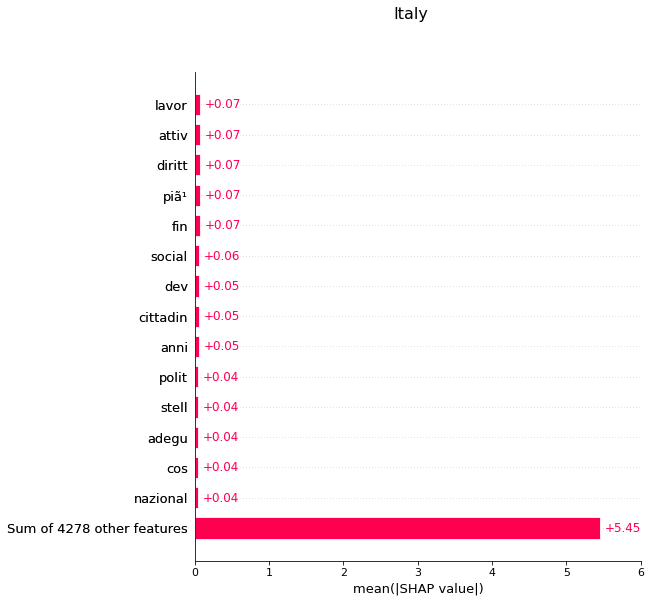

reading model for IT_manual...
reading test data for IT_manual...
Splitting train+validation and test sets


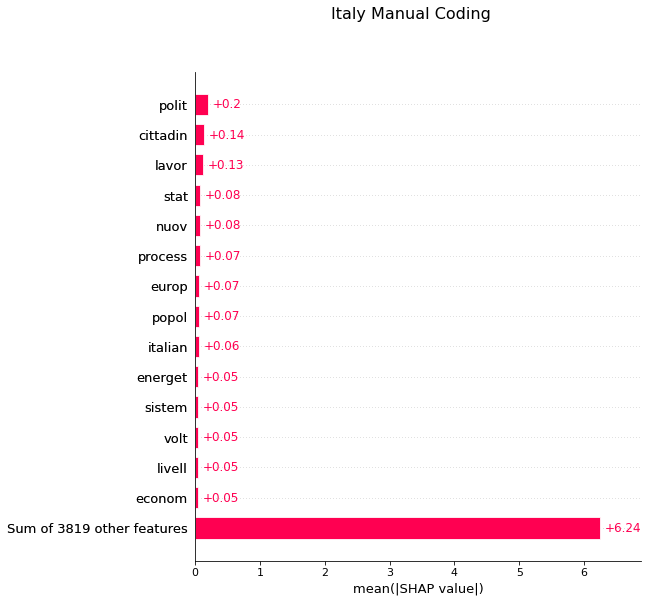

reading model for IT_speeches...
reading test data for IT_speeches...
Splitting train+validation and test sets


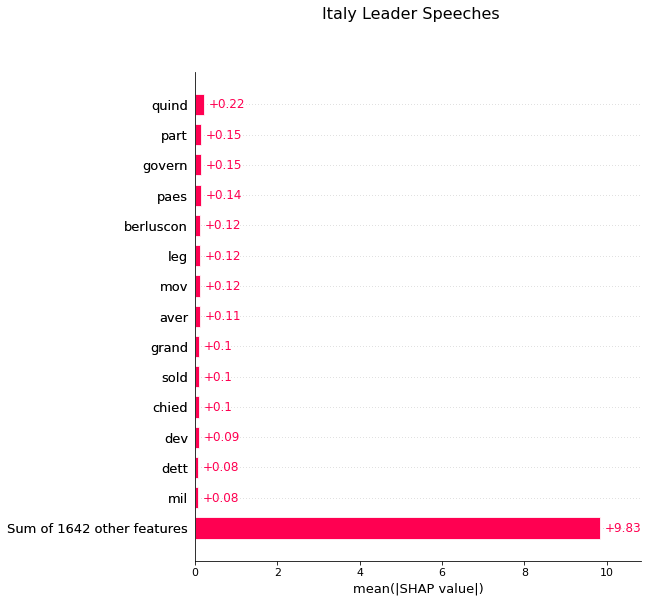

reading model for FR...
reading test data for FR...
Splitting train+validation and test sets


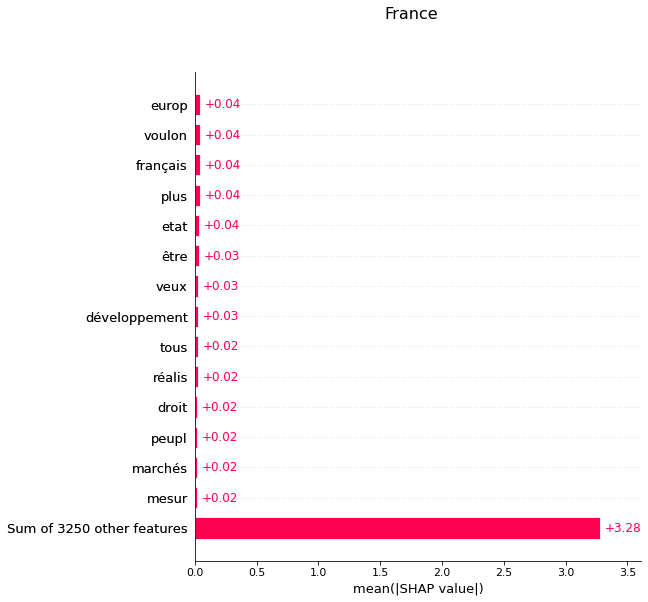

In [105]:
for nation in ["IT", "IT_manual", "IT_speeches", "FR"]:
    fig = plt.figure(figsize=(20,5))   
    fig.suptitle(nation_labels[nation], fontsize=16)
    shap_values = compute_shap_values(nation)
    shap.plots.bar(shap_values, show=False,max_display=15)
    plt.savefig("./figures/shap_values_{}.png".format(nation), dpi=300)
    plt.show()